# 0: Import packages

In [ ]:
from PIL import Image, ImageFile #pip install Pillow==9.4.0
import sys
import os
import numpy as np
import logging
import glob
import subprocess
import json
import pandas as pd

from ImageCrop import ImagePreprocessor
from SpotterWrapper import Spotter, PolygonVisualizer
from IPython.display import display
from shapely.geometry import Polygon

logging.basicConfig(level=logging.INFO)
Image.MAX_IMAGE_PIXELS=None
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 1: Specify filepaths

In [ ]:
# Name folders for raw data and processed data
map_data_topfolder = 'raw_maps_20231024'
map_strec_topfolder = 'processed/strec'

for fp in [map_strec_topfolder]:
    if not os.path.isdir(fp):
        os.makedirs(fp)

# IMPORTANT! Locate spotter directory and detectron weights
git_clone_location = 'C:/repo/'
spotter_directory = git_clone_location + 'mapkurator-spotter/spotter-v2'
model_weights = git_clone_location + 'detectron2-master/detectron2/checkpoint/model_v2_en.pth'
spotter_config = spotter_directory + '/configs/PALEJUN/Finetune/Rumsey_Polygon_Finetune.yaml'

# 2: Crop all jpeg maps in (user defined) map_data_topfolder

In [ ]:
def pyramid_scan(img_path, output_dir, save_each_layer=False):
    image = Image.open(img_path)
    image_preprocessor = ImagePreprocessor(image, overlapping_tolerance=0.3, num_layers=5, min_patch_resolution=512, max_patch_resolution=4096)
    image_preprocessor.process()
    print("preprocessing done")
    spotter = Spotter(spotter_config, model_weights, confidence_thresh=0.8, draw_thresh=0.85)
    all_layer_results = []

    base_image_batch, base_offset_xs, base_offset_ys = image_preprocessor.get_image_patches(0)
    vis = PolygonVisualizer()
    vis.canvas_from_patches(base_image_batch, base_offset_xs, base_offset_ys)

    for i in range(image_preprocessor.num_layers):
        # If you want to save for each layer, uncomment the following line
        # image_preprocessor.save_patches(os.path.join(output_dir, f'layer_{i}_patches'), layer=i)

        image_batch, offset_xs, offset_ys = image_preprocessor.get_image_patches(i)
        spotter.load_batch(image_batch, offset_xs, offset_ys)
        results = spotter.inference_batch()
        all_layer_results.extend(results)

        #all_layer_offset_xs.extend(offset_xs)
        #all_layer_offset_ys.extend(offset_ys)

        if save_each_layer == True:
            vis.draw(results).save(os.path.join(output_dir, f'combined_tagged_{i}.png'))
            vis.save_json(results, os.path.join(output_dir, f'combined_tagged_{i}.json'))
        else:
            pass

    vis.draw(all_layer_results).save(os.path.join(output_dir, f'combined_tagged_all_layers.png'))
    vis.save_json(all_layer_results, os.path.join(output_dir, f'combined_tagged_all_layers.json'))

# Run crop on all maps
for map_data_subfolder in next(os.walk(map_data_topfolder))[1]:
    jpeg_list = glob.glob(map_data_topfolder + '/' + map_data_subfolder + '/*.jpeg')
    if len(jpeg_list) != 1:
        print(map_data_subfolder + " failed. Please ensure there is exactly 1 file with extension .jpeg in the folder.")
    else:
        map_image = jpeg_list[0].split("\\")[1]
        if map_data_subfolder in ['1846_vandevelde', '1874_saunders', '1845_kiepert']: # '1858_vandevelde', '1874_saunders', '1845_kiepert']: #,,]: #'1858_vandevelde', '1847_tobler', '1845_kiepert'
            img_path = map_data_topfolder + '/' + map_data_subfolder + "/" + map_image
            map_name = os.path.basename(img_path).split('.')[0] # get the map name without extension
            output_dir = os.path.join(map_strec_topfolder, map_name)
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
            pyramid_scan(img_path, output_dir, save_each_layer=False)
            logging.info('Done cropping %s' %img_path )

# 3: Label Combination

In [ ]:
from PIL import Image, ImageFile
import json 
import pandas as pd
from collections import Counter
from shapely.geometry import Polygon, MultiPolygon
from itertools import combinations
import scipy
import numpy as np
import importlib
import Clustering
import TextRectify
import json
import pickle

importlib.reload(Clustering)
importlib.reload(TextRectify)

In [ ]:
with open('processed/strec/kiepert_1845/combined_tagged_all_layers.json', 'r', encoding='utf-8') as f:

    clustered = Clustering.cluster_polygons(json.load(f))

    # visualize clusters
    #image = Clustering.visualize_polygons(clustered, 'processed/strec/kiepert_1845/raw.jpeg')
    #image.save('processed/strec/kiepert_1845/combined_tagged_all_layers_clustering.png')

for label, cluster in clustered.items():
    texts = []
    scores = []
    for polygon in cluster:
        texts.append(polygon['text'])
        scores.append(polygon['score'])

    rectifier = TextRectify.TextRectifier(0.95, 0.5, 10, True, True)

    rectifier.feed_data(texts, scores)

    rectifier.fit()

    rectified = rectifier.get_rectified_text()

    if rectified is None:
        rectified = max(texts, key=len)

    for i in range(len(cluster)):
        cluster[i]['text'] = rectified[i]

#image = Clustering.visualize_polygons(clustered, 'processed/strec/kiepert_1845/raw.jpeg')
#image.save('processed/strec/kiepert_1845/combined_tagged_all_layers_rectified.png')

polygon_x = {}
polygon_y = {}
texts = {}
scores = {}
i = 0
for label, cluster in clustered.items():
    for polygon in cluster:
        polygon_x[str(i)] = polygon['polygon_x']
        polygon_y[str(i)] = polygon['polygon_y']
        texts[str(i)] = polygon['text']
        scores[str(i)] = polygon['score']
        i += 1

json_data = {'polygon_x': polygon_x, 'polygon_y': polygon_y, 'text': texts, 'score': scores}

with open('processed/strec/kiepert_1845/combined_tagged_all_layers_rectified.json', 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=4)

In [6]:
def load_spotter_labels(map_name_in_strec, layer_json_w_extension='combined_tagged_all_layers.json'):
    with open('processed/strec/' + map_name_in_strec + '/' + layer_json_w_extension) as f:
        spotter_labels_tmp = json.load(f)
    spotter_labels = pd.DataFrame(spotter_labels_tmp)
    spotter_labels = spotter_labels.rename(columns={'polygon_x':'all_points_x','polygon_y':'all_points_y'})
    return spotter_labels

## Convert labels to polygon objects (df needs all_points_x and all_points_y cols)
def create_polygon_object(x_coords, y_coords):
    return Polygon(zip(x_coords, y_coords)).buffer(0) # buffer fixes errors that occur due to weird self-overlapping edges when manually labeling

def cast_coords_as_Polygons(df):
    df_copy = df.copy()
    df_copy.loc[:, 'label_polygons'] = df.apply(lambda row: create_polygon_object(row['all_points_x'], row['all_points_y']), axis=1)
    return df_copy
    
def intersection_over_minimum(obj1, obj2):
    if (isinstance(obj1, Polygon) or isinstance(obj1, MultiPolygon)) and (isinstance(obj2, Polygon) or isinstance(obj2, MultiPolygon)):
        IoM = obj1.intersection(obj2).area / min(obj1.area, obj2.area)
    elif isinstance(obj1, str) and isinstance(obj2, str):
        obj1 = obj1.lower()
        obj2 = obj2.lower()
        cntr1 = Counter(obj1)
        cntr2 = Counter(obj2)
        global_char_set = set(cntr1.keys()) | set(cntr2.keys())
        IoM = sum(min(cntr1[char], cntr2[char]) for char in global_char_set) / min(len(obj1), len(obj2))
    else:
        print(obj1, obj2)
        print("both inputs must be of the same type (Polygon or string)")
        IoM = np.nan
    return IoM

def IoMs(label1, label2):
    poly1 = label1[0]
    text1 = label1[1]
    poly2 = label2[0]
    text2 = label2[1]
    if len(set(text1.lower()) | set(text2.lower())) == 0:
        return (0, 0)
    if not poly1.intersects(poly2):
        return (0, 0)
    poly_IoU = intersection_over_minimum(poly1, poly2)
    text_IoU = intersection_over_minimum(text1, text2)
    return (poly_IoU, text_IoU)

def update_P_matrix(df_w_labels, geo_threshold, text_threshold, P = None):
    labels = df_w_labels['labels']
    if P == None:
        P = {}
    to_combine = []
    for i, j in combinations(labels.index, 2):
        if i not in P.keys():
            P[i] = {}
        if j in P[i].keys():
            pass
        else:
            similarity = IoMs(labels[i], labels[j])
            P[i][j] = similarity
            if similarity[0] > geo_threshold and similarity[1] > text_threshold:
                to_combine.append((i,j))
    return P, to_combine

def combine_labels(label1, label2):
    poly1 = label1[0]
    text1 = label1[1]
    poly2 = label2[0]
    text2 = label2[1]
    poly_new = poly1.union(poly2)
    text_new = text1 if len(text1) > len(text2) else text2
    return (poly_new, text_new)

def amalgamate_labels(df, P, to_combine):
    for pair in to_combine:
        if str(pair[0]) in df.index and str(pair[1]) in df.index:
            new_label = combine_labels(df.loc[str(pair[0])]['labels'], df.loc[str(pair[1])]['labels'])
            df.loc[str(int(df.index[-1]) + 1)] = [new_label]
            df = df.drop([str(pair[0])]).copy()
            df = df.drop([str(pair[1])]).copy()
            try:
                P.pop(pair[0])
            except:
                pass
            try:
                P.pop(pair[1])
            except:
                pass
        else: # one of the polygons has already been swallowed so no combination can no longer occur
            pass
    return df, P

def amalgamate_labels_wrapper(df, geo_threshold, text_threshold):
    pre_amal = 0
    post_amal = len(df)
    P = None
    while pre_amal - post_amal != 0:
        pre_amal = post_amal
        P, to_combine = update_P_matrix(df, geo_threshold, text_threshold, P)
        print(str(pre_amal) + " labels.")
        df, P = amalgamate_labels(df, P, to_combine)
        post_amal = len(df)
    print("Amalgamation completed with " + str(pre_amal) + " labels.")
    return df

df = load_spotter_labels("kiepert_1845", "combined_tagged_all_layers_rectified.json")
df = cast_coords_as_Polygons(df)
df['labels'] = df.apply(lambda row: (row['label_polygons'], row['text']), axis=1)
df = df[['labels']]
df = amalgamate_labels_wrapper(df, 0.75, .5)


In [ ]:
import pickle

with open('amalgamate.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
result = list(df["labels"])
polygons = []
texts = []

import shapely as sh
import shapely.geometry as sg

#result[0][0].exterior.coords.xy[0]

for i in range(len(result)):
    poly = result[i][0]
    polygons.append(poly)
    texts.append(result[i][1])

In [ ]:
#reload SpotterWrapper module
import importlib
import SpotterWrapper
importlib.reload(SpotterWrapper)

vis = SpotterWrapper.PolygonVisualizer()
canvas = Image.open('processed/strec/kiepert_1845/raw.jpeg')
vis.canvas_from_image(canvas)

vis.draw_poly(polygons, texts)

# 4: Evaluation

full map is 6529 pixels wide by 8695 pixels high.
 displaying crop:


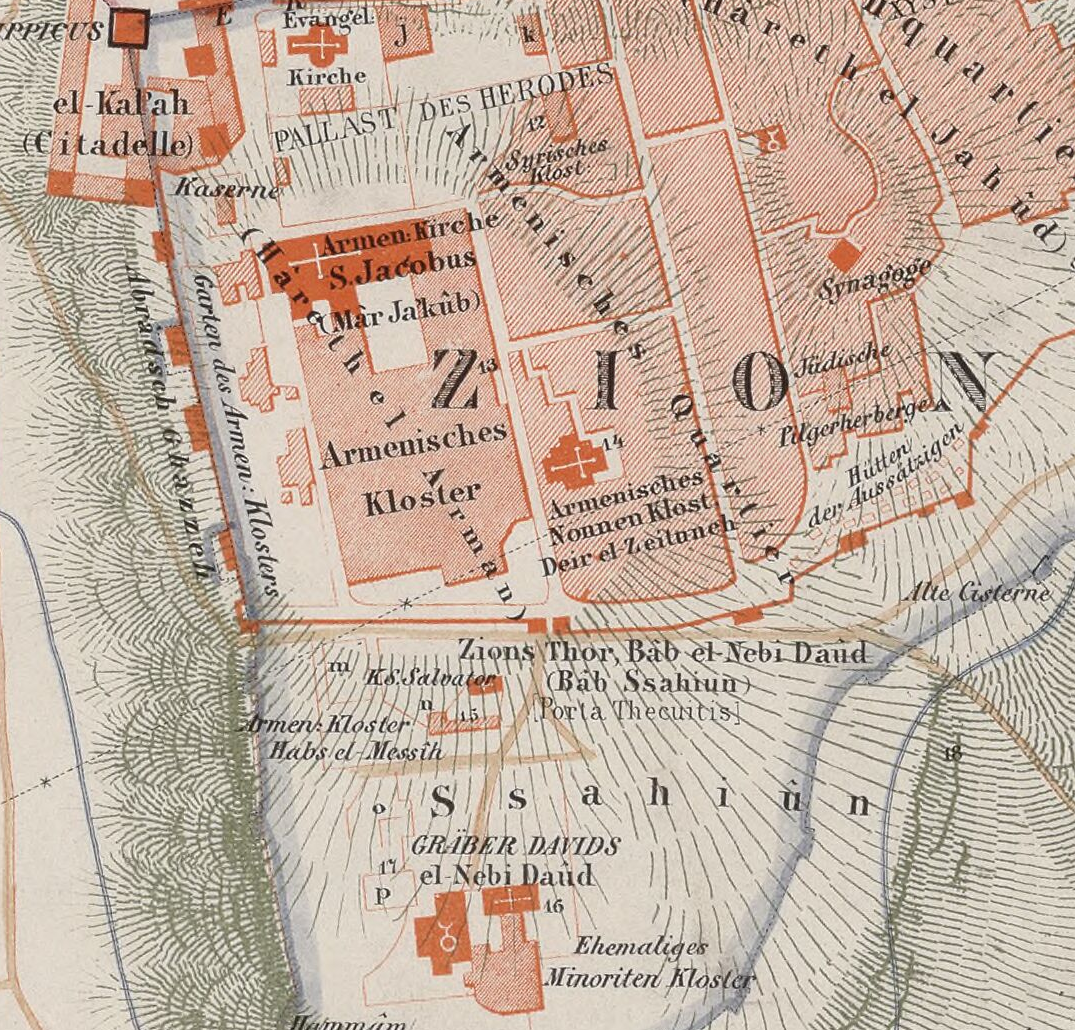

In [295]:
from PIL import Image, ImageFile
import json 
import pandas as pd
from collections import Counter
from shapely.geometry import Polygon, MultiPolygon
from itertools import combinations
import scipy
import numpy as np
import re
import unidecode


def visualize_crop(map_name_in_strec, raw_or_spotter, left_x, right_x, top_y, bottom_y):
    if raw_or_spotter == "raw":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/raw.jpeg') 
    elif raw_or_spotter == "spotter_0":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/combined_tagged_0.png')
    elif raw_or_spotter == "spotter_1":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/combined_tagged_1.png')
    elif raw_or_spotter == "spotter_2":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/combined_tagged_2.png')
    elif raw_or_spotter == "all":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/combined_tagged_all_layers.png')
    elif raw_or_spotter == "rectified":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/combined_tagged_all_layers_rectified.png')
    width, height = map_img.size
    print("full map is " + str(width) + " pixels wide by " + str(height) + " pixels high.\n displaying crop:")
    display(map_img.crop((left_x, top_y, right_x, bottom_y, )))

left_x = 2475
right_x = 3550
top_y = 4820
bottom_y = 5850

visualize_crop("kiepert_1845", "raw", left_x, right_x, top_y, bottom_y)

In [328]:
# FUNCTIONS

## Load in (1) ground truth labels that were built using Via and (2) rectified spotter polygons
def load_ground_truth_labels(map_name_in_strec, multiline_handling, labels_on_fullsize_map=True):
    with open('dependencies/ground_truth_labels/' + map_name_in_strec + '.json') as f:
        gt_labels_tmp = json.load(f)
        gt_labels = pd.DataFrame([
            {
                'all_points_x': obs['shape_attributes']['all_points_x'],
                'all_points_y': obs['shape_attributes']['all_points_y'],
                'annotation': obs['region_attributes']['annotation'],
                'multiline_g': obs['region_attributes'].get('multiline_g', None)
            }
            for obs in gt_labels_tmp[list(gt_labels_tmp.keys())[0]]['regions']
        ])

    if multiline_handling == 'largest':
        gt_labels['annotation_length'] = gt_labels['annotation'].apply(len)
        tmp1 = gt_labels[gt_labels['multiline_g'].isnull()]
        tmp2 = gt_labels.dropna(subset=['multiline_g'])
        gt_labels = pd.concat([tmp2.loc[tmp2.groupby('multiline_g')['annotation_length'].idxmax()], tmp1])
    elif multiline_handling == 'components':
        gt_labels['annotation_length'] = gt_labels['annotation'].apply(len)
        tmp1 = gt_labels[gt_labels['multiline_g'].isnull()]
        tmp2 = gt_labels.dropna(subset=['multiline_g'])
        gt_labels = pd.concat([tmp2.loc[~tmp2.index.isin(tmp2.groupby('multiline_g')['annotation_length'].idxmax())], tmp1])
    return gt_labels

def load_rectified_polygons(map_name_in_strec):
    df = pickle.load(open('processed/strec/' + map_name_in_strec + '/refined_labels.pickle', 'rb'))
    df = pd.DataFrame(df['labels'].tolist(), columns=['label_polygons','annotation'])
    return df

## Retain a subset of labels based on crop coordinates
def coords_fail_condition(list, direction_for_drop, value, baseline):
    if baseline == 1:
        return 1
    else:
        if direction_for_drop == '<':
            num_coords_broke_rule = sum([0 if coord < value else 1 for coord in list])
        elif direction_for_drop == '>':
            num_coords_broke_rule = sum([0 if coord > value else 1 for coord in list])
        if num_coords_broke_rule > 0:
            return 1
        else:
            return 0
        
def polygon_fail_condition(object, x_0_or_y_1, direction_for_drop, value, baseline):
    if baseline == 1:
        return 1
    else:
        if direction_for_drop == '<':
            if isinstance(object, Polygon):
                poly_broke_rule = any(coord[x_0_or_y_1] > value for coord in object.exterior.coords)
            elif isinstance(object, MultiPolygon):
                poly_broke_rule = any(any(coord[x_0_or_y_1] > value for coord in poly.exterior.coords) for poly in object.geoms)
        elif direction_for_drop == '>':
            if isinstance(object, Polygon):
                poly_broke_rule = any(coord[x_0_or_y_1] < value for coord in object.exterior.coords)
            elif isinstance(object, MultiPolygon):
                poly_broke_rule = any(any(coord[x_0_or_y_1] < value for coord in poly.exterior.coords) for poly in object.geoms)
        if poly_broke_rule == True:
            return 1
        else:
            return 0
        
def retain_crop_coords_only(df, left_x, right_x, top_y, bottom_y):
    df['drop'] = 0
    df['drop'] = df.apply(lambda row: coords_fail_condition(row['all_points_x'], '>', left_x, row['drop']), axis=1)
    df['drop'] = df.apply(lambda row: coords_fail_condition(row['all_points_x'], '<', right_x, row['drop']), axis=1)
    df['drop'] = df.apply(lambda row: coords_fail_condition(row['all_points_y'], '>', top_y, row['drop']), axis=1)
    df['drop'] = df.apply(lambda row: coords_fail_condition(row['all_points_y'], '<', bottom_y, row['drop']), axis=1)
    df = df[df['drop'] == 0]
    print("retaining " + str(len(df)) + " labels fully inside crop area")
    return df

def retain_crop_polygons_only(df, left_x, right_x, top_y, bottom_y):
    df['drop'] = 0
    df['drop'] = df.apply(lambda row: polygon_fail_condition(row['label_polygons'], 0, '>', left_x, row['drop']), axis=1)
    df['drop'] = df.apply(lambda row: polygon_fail_condition(row['label_polygons'], 0, '<', right_x, row['drop']), axis=1)
    df['drop'] = df.apply(lambda row: polygon_fail_condition(row['label_polygons'], 1, '>', top_y, row['drop']), axis=1)
    df['drop'] = df.apply(lambda row: polygon_fail_condition(row['label_polygons'], 1, '<', bottom_y, row['drop']), axis=1)
    df = df[df['drop'] == 0]
    print("retaining " + str(len(df)) + " labels fully inside crop area")
    return df

def remove_non_alphabetical_characters_and_accents(string):
    string = unidecode.unidecode(string.lower())
    string = re.sub(r'[^a-zA-Z ]+', '', string)
    return string

def retain_alphabetic_annotations_only(df):
    df.loc[:, 'drop_txt'] = 0
    df['annotation_stripped'] = df['annotation'].apply(remove_non_alphabetical_characters_and_accents)
    df.loc[df['annotation_stripped'].str.len() == 0, 'drop_txt'] = 1
    df = df[df['drop_txt'] == 0]
    print("retaining " + str(len(df)) + " labels that have alphabetic characters")
    return df

## Calculate and Match IoUs
def calculate_IoU_matrix(spotter_labels, gt_labels):
    IoU_matrix = []
    for sptr_lab in spotter_labels:
        row = []
        for gt_lab in gt_labels:
            intersection_area = sptr_lab[0].intersection(gt_lab[0]).area
            union_area = sptr_lab[0].union(gt_lab[0]).area
            iou = intersection_area / union_area if union_area > 0 else 0
            row.append((iou, sptr_lab[1], gt_lab[1]))
        IoU_matrix.append(row)
    return np.array(IoU_matrix)

def maximize_1to1_IoU(IoU_matrix):
    IoUs_only = np.array([[float(col[0]) for col in row] for row in IoU_matrix])
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(IoUs_only, maximize=True)
    IoU_pairs = IoU_matrix[row_ind, col_ind]
    return IoU_pairs

## Full pipeline 
def geographic_evaluation(map_name_in_strec, multiline_handling, coords, spotter_target = 'rectified'):
    left_x = coords[0]
    right_x = coords[1]
    top_y = coords[2]
    bottom_y = coords[3]
    print("\n------")
    print(map_name_in_strec + " | " + multiline_handling + " of multiline GT labels")
    print("------")
    gt_labels_full = load_ground_truth_labels(map_name_in_strec, multiline_handling)
    gt_labels_crop = retain_crop_coords_only(gt_labels_full, left_x, right_x, top_y, bottom_y)
    gt_labels_crop = retain_alphabetic_annotations_only(gt_labels_crop)
    gt_labels_crop = cast_coords_as_Polygons(gt_labels_crop)

    if spotter_target == 'rectified':
        spotter_labels_full = load_rectified_polygons(map_name_in_strec)
        spotter_labels_crop = retain_crop_polygons_only(spotter_labels_full, left_x, right_x, top_y, bottom_y)
    else:
        spotter_labels_full = load_spotter_labels(map_name_in_strec, spotter_target)
        spotter_labels_crop = retain_crop_coords_only(spotter_labels_full, left_x, right_x, top_y, bottom_y)
        spotter_labels_crop = cast_coords_as_Polygons(spotter_labels_crop)
        spotter_labels_crop.rename(columns={'text': 'annotation'}, inplace=True)
    spotter_labels_crop = retain_alphabetic_annotations_only(spotter_labels_crop)

    IoU_matrix = calculate_IoU_matrix(list(spotter_labels_crop[['label_polygons', 'annotation']].itertuples(index=False, name=None)), list(gt_labels_crop[['label_polygons', 'annotation']].itertuples(index=False, name=None)))
    num_detected = IoU_matrix.shape[0]
    num_gt = IoU_matrix.shape[1]
    IoU_pairs = maximize_1to1_IoU(IoU_matrix)
    return num_detected, num_gt, IoU_pairs

def edit_distance_similarity(word1, word2):
    m, n = len(word1), len(word2)
    if m == 0 or n == 0:
        return -1
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if word1[i - 1] == word2[j - 1]:
                cost = 0
            else:
                cost = 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)

    return 1 - pow(dp[m][n] / max(len(word1), len(word2)), 0.5)

def text_compare(s1, s2):
    s1_lwr_26 = remove_non_alphabetical_characters_and_accents(s1)
    s2_lwr_26 = remove_non_alphabetical_characters_and_accents(s2)
    return edit_distance_similarity(s1_lwr_26, s2_lwr_26)

In [289]:
num_detected, num_gt, IoU_pairs = geographic_evaluation("kiepert_1845", "components")
IoU_pairs = pd.DataFrame(IoU_pairs, columns=['geo_IoU', 'spotter_txt', 'gt_txt'])

print("Avg of Geographic Precision: " + str(IoU_pairs['geo_IoU'].astype(float).sum(axis=0) / num_detected))
print("Avg of Geographic Recall: " + str(IoU_pairs['geo_IoU'].astype(float).sum(axis=0) / num_gt))

IoU_pairs['normalized_txt_similarity'] = IoU_pairs.apply(lambda row: text_compare(row['spotter_txt'], row['gt_txt']), axis=1)

print("Avg of Text Precision: " + str(IoU_pairs['normalized_txt_similarity'].astype(float).sum(axis=0) / num_detected))
print("Avg of Text Recall: " + str(IoU_pairs['normalized_txt_similarity'].astype(float).sum(axis=0) / num_gt))


------
kiepert_1845 | components of multiline GT labels
------
retaining 52 labels fully inside crop area
retaining 46 labels that have alphabetic characters


C:\Users\HP\AppData\Local\Temp\ipykernel_1624\2305480865.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'drop_txt'] = 0
C:\Users\HP\AppData\Local\Temp\ipykernel_1624\2305480865.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['annotation_stripped'] = df['annotation'].apply(remove_non_alphabetical_characters_and_accents)
C:\Users\HP\AppData\Local\Temp\ipykernel_1624\2305480865.py:30: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will 

retaining 85 labels fully inside crop area
retaining 80 labels that have alphabetic characters
Avg of Geographic Precision: 0.3380897523346257
Avg of Geographic Recall: 0.5879821779732621
Avg of Text Precision: 0.3094107899375469
Avg of Text Recall: 0.5381057216305163


C:\Users\HP\AppData\Local\Temp\ipykernel_1624\2305480865.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'drop_txt'] = 0
C:\Users\HP\AppData\Local\Temp\ipykernel_1624\2305480865.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['annotation_stripped'] = df['annotation'].apply(remove_non_alphabetical_characters_and_accents)


In [290]:
num_detected, num_gt, IoU_pairs = geographic_evaluation("kiepert_1845", "components", "combined_tagged_0.json")
IoU_pairs = pd.DataFrame(IoU_pairs, columns=['geo_IoU', 'spotter_txt', 'gt_txt'])

print("Avg of Geographic Precision: " + str(IoU_pairs['geo_IoU'].astype(float).sum(axis=0) / num_detected))
print("Avg of Geographic Recall: " + str(IoU_pairs['geo_IoU'].astype(float).sum(axis=0) / num_gt))

IoU_pairs['normalized_txt_similarity'] = IoU_pairs.apply(lambda row: text_compare(row['spotter_txt'], row['gt_txt']), axis=1)

print("Avg of Text Precision: " + str(IoU_pairs['normalized_txt_similarity'].astype(float).sum(axis=0) / num_detected))
print("Avg of Text Recall: " + str(IoU_pairs['normalized_txt_similarity'].astype(float).sum(axis=0) / num_gt))


------
kiepert_1845 | components of multiline GT labels
------
retaining 52 labels fully inside crop area
retaining 46 labels that have alphabetic characters
retaining 32 labels fully inside crop area
retaining 32 labels that have alphabetic characters
Avg of Geographic Precision: 0.20668536767065082
Avg of Geographic Recall: 0.14378112533610493
Avg of Text Precision: 0.11923366030059544
Avg of Text Recall: 0.08294515499171858


C:\Users\HP\AppData\Local\Temp\ipykernel_1624\2305480865.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'drop_txt'] = 0
C:\Users\HP\AppData\Local\Temp\ipykernel_1624\2305480865.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['annotation_stripped'] = df['annotation'].apply(remove_non_alphabetical_characters_and_accents)


In [ ]:
# Aggregate versions

num_detected_kiepert, num_gt_kiepert, IoU_pairs_kiepert = geographic_evaluation("kiepert_1845", "components", [2475, 3550, 4820, 5850])
num_detected_saunders1, num_gt_saunders1, IoU_pairs_saunders1 = geographic_evaluation("saunders_1874", "components", [3150, 4150, 2250, 3250])
num_detected_saunders2, num_gt_saunders2, IoU_pairs_saunders2 = geographic_evaluation("saunders_1874", "components", [6750, 7750, 2250, 3250])
num_detected_saunders3, num_gt_saunders3, IoU_pairs_saunders3 = geographic_evaluation("saunders_1874", "components", [5400, 6400, 4500, 5500])
num_detected_saunders4, num_gt_saunders4, IoU_pairs_saunders4 = geographic_evaluation("saunders_1874", "components", [7650, 8650, 5400, 6400])
num_detected_saunders5, num_gt_saunders5, IoU_pairs_saunders5 = geographic_evaluation("saunders_1874", "components", [7650, 8650, 3150, 4150])

num_gt_kiepert = num_gt_kiepert
num_gt_saunders = num_gt_saunders1 + num_gt_saunders2 + num_gt_saunders3 + num_gt_saunders4 + num_gt_saunders5
num_detected_pyramid_kiepert = num_detected_kiepert
num_detected_pyramid_saunders = num_detected_saunders1 + num_detected_saunders2 + num_detected_saunders3 + num_detected_saunders4 + num_detected_saunders5
IoU_pairs_pyramid_kiepert = IoU_pairs_kiepert
IoU_pairs_pyramid_saunders = np.concatenate((IoU_pairs_saunders1, IoU_pairs_saunders2, IoU_pairs_saunders3, IoU_pairs_saunders4, IoU_pairs_saunders5))

num_detected_kiepert, num_gt_kiepert, IoU_pairs_kiepert = geographic_evaluation("kiepert_1845", "components", [2475, 3550, 4820, 5850], "combined_tagged_0.json")
num_detected_saunders1, num_gt_saunders1, IoU_pairs_saunders1 = geographic_evaluation("saunders_1874", "components", [3150, 4150, 2250, 3250], "combined_tagged_0.json")
num_detected_saunders2, num_gt_saunders2, IoU_pairs_saunders2 = geographic_evaluation("saunders_1874", "components", [6750, 7750, 2250, 3250], "combined_tagged_0.json")
num_detected_saunders3, num_gt_saunders3, IoU_pairs_saunders3 = geographic_evaluation("saunders_1874", "components", [5400, 6400, 4500, 5500], "combined_tagged_0.json")
num_detected_saunders4, num_gt_saunders4, IoU_pairs_saunders4 = geographic_evaluation("saunders_1874", "components", [7650, 8650, 5400, 6400], "combined_tagged_0.json")
num_detected_saunders5, num_gt_saunders5, IoU_pairs_saunders5 = geographic_evaluation("saunders_1874", "components", [7650, 8650, 3150, 4150], "combined_tagged_0.json")

num_detected_flat_kiepert = num_detected_kiepert
num_detected_flat_saunders = num_detected_saunders1 + num_detected_saunders2 + num_detected_saunders3 + num_detected_saunders4 + num_detected_saunders5
IoU_pairs_flat_saunders = np.concatenate((IoU_pairs_saunders1, IoU_pairs_saunders2, IoU_pairs_saunders3, IoU_pairs_saunders4, IoU_pairs_saunders5))




In [343]:
def prec_rec(IoU_pairs, num_detected, num_gt):
    print("Avg of Geographic Precision: " + str(IoU_pairs['geo_IoU'].astype(float).sum(axis=0) / num_detected))
    print("Avg of Geographic Recall: " + str(IoU_pairs['geo_IoU'].astype(float).sum(axis=0) / num_gt))
    IoU_pairs['normalized_txt_similarity'] = IoU_pairs.apply(lambda row: text_compare(row['spotter_txt'], row['gt_txt']), axis=1)
    print("Avg of Text Precision: " + str(IoU_pairs['normalized_txt_similarity'].astype(float).sum(axis=0) / num_detected))
    print("Avg of Text Recall: " + str(IoU_pairs['normalized_txt_similarity'].astype(float).sum(axis=0) / num_gt))

In [344]:
IoU_pairs = pd.DataFrame(IoU_pairs_pyramid_kiepert, columns=['geo_IoU', 'spotter_txt', 'gt_txt'])
prec_rec(IoU_pairs, num_detected_pyramid_kiepert, num_gt_kiepert)
IoU_pairs = pd.DataFrame(IoU_pairs_pyramid_saunders, columns=['geo_IoU', 'spotter_txt', 'gt_txt'])
prec_rec(IoU_pairs, num_detected_pyramid_saunders, num_gt_saunders)


Avg of Geographic Precision: 0.3380897523346257
Avg of Geographic Recall: 0.5879821779732621
Avg of Text Precision: 0.3094107899375469
Avg of Text Recall: 0.5381057216305163
Avg of Geographic Precision: 0.1818085650660818
Avg of Geographic Recall: 0.574749657305678
Avg of Text Precision: 0.1411147502394463
Avg of Text Recall: 0.44610469430534644


In [345]:
IoU_pairs = pd.DataFrame(IoU_pairs_flat_saunders, columns=['geo_IoU', 'spotter_txt', 'gt_txt'])
prec_rec(IoU_pairs, num_detected_flat_saunders, num_gt_saunders)

Avg of Geographic Precision: 0.10525859355486396
Avg of Geographic Recall: 0.09959952938524762
Avg of Text Precision: 0.07932917689981656
Avg of Text Recall: 0.07506416738907373


In [349]:
num_gt_saunders, num_detected_flat_saunders, num_detected_pyramid_saunders

(93, 88, 294)

In [352]:
num_gt_kiepert, num_detected_flat_kiepert, num_detected_pyramid_kiepert

(46, 32, 80)